# Declarando as bibliotecas e importando o dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model,Input
from tensorflow import keras
from sklearn.metrics import classification_report
import os
import cv2
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import Resize, Compose
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [21]:
import torchvision.models as models
import torch.nn as nn

In [3]:
dataset_dir = "raw-img"

images_path = []
labels = []

In [4]:
for index,value in enumerate(os.listdir(dataset_dir)):
    path = os.path.join(dataset_dir,value)
    num = 0
    for i in os.listdir(path):
        if num==5000:
            break
        num+=1
        images = os.path.join(path,i)
        images_path.append(images)
        labels.append(value)

In [5]:
data = pd.DataFrame({
    'images_path' : images_path,
    'labels' : labels
})

In [6]:
label = {"cane": "dog",
         "cavallo": "horse",
         "elefante": "elephant",
         "farfalla": "butterfly",
         "gallina": "chicken",
         "gatto": "cat",
         "mucca": "cow",
         "pecora": "sheep",
         "ragno" : "spider",
         "scoiattolo": "squirrel"}

label_to_index = {key: idx for idx, key in enumerate(label.keys())}
index_to_label = {idx: value for key, value in label.items() for idx, k in enumerate(label.keys()) if k == key}

In [7]:
data['labels_num'] = data['labels'].map(label_to_index)
data['labels'] = data['labels'].map(label)

In [8]:
print("Estrutura do DataFrame:")
print(data.head())

Estrutura do DataFrame:
                                        images_path labels  labels_num
0      raw-img\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg    dog           0
1  raw-img\cane\OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg    dog           0
2  raw-img\cane\OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg    dog           0
3  raw-img\cane\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg    dog           0
4  raw-img\cane\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg    dog           0


C:\Users\elisa\AppData\Local\Temp\ipykernel_504\400510233.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['labels'], order=data['labels'].value_counts().index, palette="viridis")


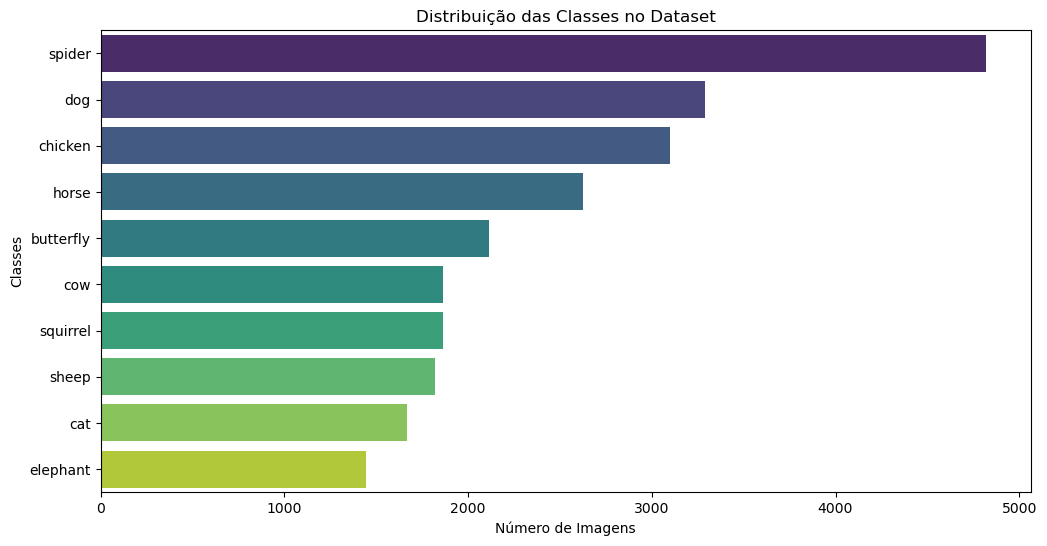

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(y=data['labels'], order=data['labels'].value_counts().index, palette="viridis")
plt.title("Distribuição das Classes no Dataset")
plt.xlabel("Número de Imagens")
plt.ylabel("Classes")
plt.show()

In [10]:
def show_sample_images(data, label_column='labels', n_samples=5):
    """Função para exibir amostras de imagens com suas respectivas classes."""
    sample_data = data.sample(n_samples)  

    plt.figure(figsize=(15, 10))
    for idx, (image_path, label) in enumerate(zip(sample_data['images_path'], sample_data[label_column])):
        plt.subplot(1, n_samples, idx + 1)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"Classe: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

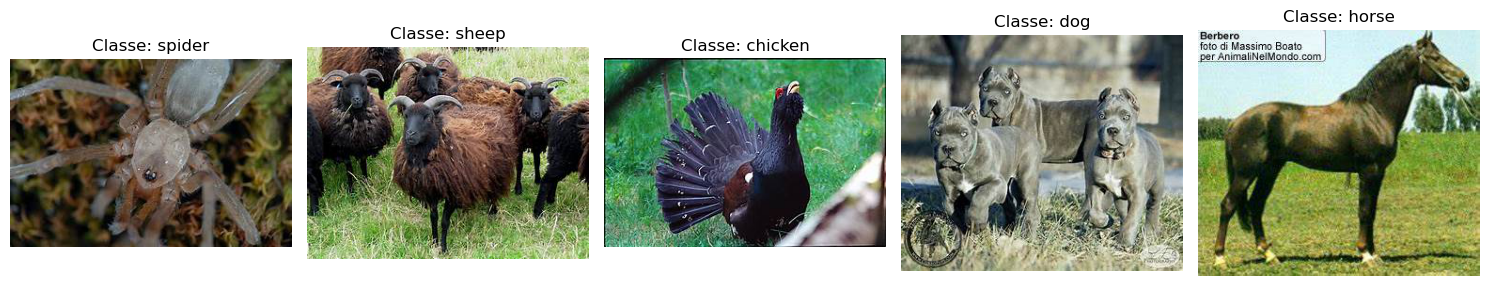

In [12]:
show_sample_images(data, n_samples=5)

# Pré-processamento e divisão dos dados

In [14]:
batch_size = 32
image_size = 224

In [15]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),        # Rotação aleatória
    transforms.RandomHorizontalFlip(),    # Espelhamento horizontal
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Crop com zoom
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Ajuste de cores
    transforms.ToTensor(),                # Conversão para tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalização (ImageNet)
])

In [16]:
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # Redimensiona para o tamanho fixo
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalização
])

In [17]:
dataset = ImageFolder(root=dataset_dir, transform=train_transforms)

In [18]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [19]:
val_dataset.dataset.transform = val_transforms

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Modelo pré-treinado

In [22]:
vgg16 = models.vgg16(pretrained=True)

C:\Users\elisa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\elisa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\elisa/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [01:06<00:00, 8.28MB/s]


In [23]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [24]:
num_classes = 10
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)  
)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [26]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

## Feature Extraction


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0

        # Treinamento
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validação
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_acc / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Exibir os resultados da época atual
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        print("-" * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [36]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=vgg16,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10
)

Epoch 1/10
Train Loss: 0.1292, Train Accuracy: 0.9596
Val Loss: 0.1604, Val Accuracy: 0.9590
--------------------------------------------------
Epoch 2/10
Train Loss: 0.1342, Train Accuracy: 0.9590
Val Loss: 0.1490, Val Accuracy: 0.9630
--------------------------------------------------
Epoch 3/10
Train Loss: 0.1200, Train Accuracy: 0.9610
Val Loss: 0.1611, Val Accuracy: 0.9618
--------------------------------------------------
Epoch 4/10
Train Loss: 0.1176, Train Accuracy: 0.9631
Val Loss: 0.1634, Val Accuracy: 0.9608
--------------------------------------------------
Epoch 5/10
Train Loss: 0.1172, Train Accuracy: 0.9635
Val Loss: 0.1582, Val Accuracy: 0.9622
--------------------------------------------------
Epoch 6/10
Train Loss: 0.1174, Train Accuracy: 0.9657
Val Loss: 0.1670, Val Accuracy: 0.9598
--------------------------------------------------
Epoch 7/10
Train Loss: 0.1179, Train Accuracy: 0.9648
Val Loss: 0.1584, Val Accuracy: 0.9604
-------------------------------------------

In [37]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [39]:
train_losses

[0.12915766606843077,
 0.1341937283593927,
 0.12002439972409822,
 0.11760429848890182,
 0.11716504516176404,
 0.11743193336682357,
 0.11793697196683504,
 0.12216581461821492,
 0.11212157857094157,
 0.12417704127716656]

In [40]:
val_losses

[0.16042555449804513,
 0.14901683159102988,
 0.1610828254163241,
 0.1634215621708389,
 0.1582236393920279,
 0.1669539068837827,
 0.1583601075323607,
 0.1705395202526623,
 0.1627104966809112,
 0.17117052001034985]

In [41]:
train_accuracies

[0.9595631191262383,
 0.9590043180086361,
 0.9609855219710439,
 0.9631191262382525,
 0.9634747269494539,
 0.9657099314198628,
 0.9648463296926594,
 0.9627127254254508,
 0.965252730505461,
 0.9647955295910592]

In [42]:
val_accuracies

[0.9589597724502235,
 0.963023161316538,
 0.9618041446566437,
 0.960788297440065,
 0.9622104835432751,
 0.9597724502234863,
 0.9603819585534336,
 0.9620073140999593,
 0.9611946363266964,
 0.9599756196668021]

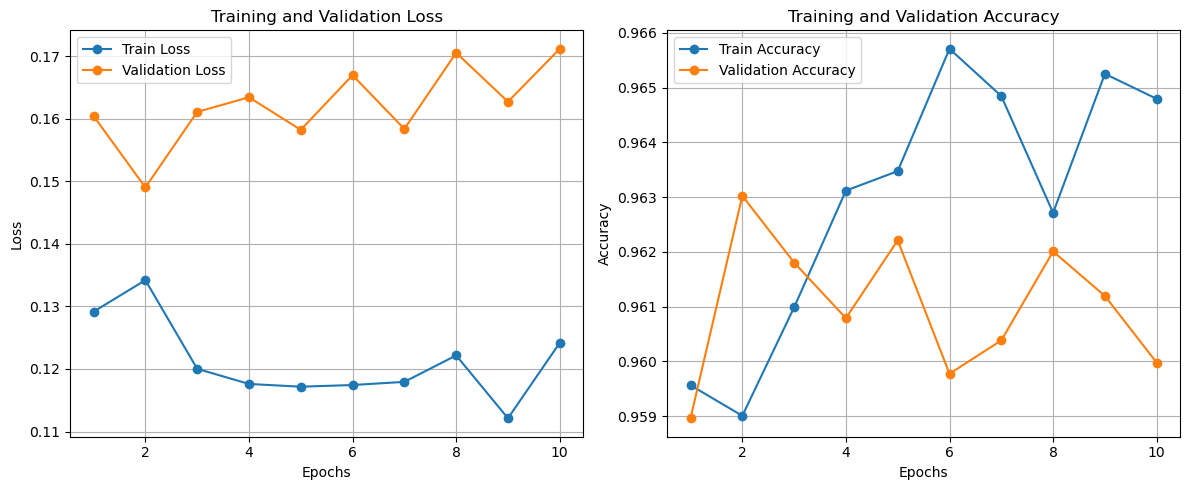

In [38]:
# Plotar os resultados
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

## Fine-Tuning


In [12]:
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['labels_num'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels_num'], random_state=42)


In [13]:
print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de validação: {len(val_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

Tamanho do conjunto de treino: 17224
Tamanho do conjunto de validação: 3691
Tamanho do conjunto de teste: 3692


In [ ]:
x_train = load_and_preprocess_images(train_df['images_path'])
y_train = train_df['labels_num'].values

x_val = load_and_preprocess_images(val_df['images_path'])
y_val = val_df['labels_num'].values

x_test = load_and_preprocess_images(test_df['images_path'])
y_test = test_df['labels_num'].values

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 0.18,
    zoom_range = 0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [16]:
val_datagen = ImageDataGenerator() 

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)
test_generator = val_datagen.flow(x_test, y_test, batch_size=32, shuffle=False)

In [ ]:
base_model = VGG16(
    input_shape = (224,224,3),
    include_top = False,
)

In [ ]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)  # 10 classes no dataset Animals-10

In [23]:
conv_layers = {}

for index, layer in enumerate(vgg16_1.layers):
    if isinstance(layer, (keras.layers.Flatten, keras.layers.Dense)):
        break
    else: 
        conv_layers[index] = layer.name
conv_layers

{0: 'input_1',
 1: 'block1_conv1',
 2: 'block1_conv2',
 3: 'block1_pool',
 4: 'block2_conv1',
 5: 'block2_conv2',
 6: 'block2_pool',
 7: 'block3_conv1',
 8: 'block3_conv2',
 9: 'block3_conv3',
 10: 'block3_pool',
 11: 'block4_conv1',
 12: 'block4_conv2',
 13: 'block4_conv3',
 14: 'block4_pool',
 15: 'block5_conv1',
 16: 'block5_conv2',
 17: 'block5_conv3',
 18: 'block5_pool'}

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [52]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 10  

In [53]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [54]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [55]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [56]:
vgg16 = models.vgg16(pretrained=True)

In [57]:
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

In [58]:
params_to_update = [param for param in vgg16.parameters() if param.requires_grad]


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=learning_rate)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [62]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
        
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [63]:
train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10 - Train Loss: 0.8373, Train Acc: 0.8718 - Val Loss: 0.3679, Val Acc: 0.9216
Epoch 2/10 - Train Loss: 0.7737, Train Acc: 0.9231 - Val Loss: 0.8304, Val Acc: 0.9128
Epoch 3/10 - Train Loss: 0.7790, Train Acc: 0.9368 - Val Loss: 0.6284, Val Acc: 0.9372
Epoch 4/10 - Train Loss: 0.6792, Train Acc: 0.9493 - Val Loss: 0.7202, Val Acc: 0.9431
Epoch 5/10 - Train Loss: 0.7042, Train Acc: 0.9583 - Val Loss: 1.0175, Val Acc: 0.9429
Epoch 6/10 - Train Loss: 1.1512, Train Acc: 0.9575 - Val Loss: 1.4966, Val Acc: 0.9295
Epoch 7/10 - Train Loss: 0.7952, Train Acc: 0.9679 - Val Loss: 1.5293, Val Acc: 0.9431
Epoch 8/10 - Train Loss: 0.8205, Train Acc: 0.9726 - Val Loss: 1.7200, Val Acc: 0.9484
Epoch 9/10 - Train Loss: 0.9655, Train Acc: 0.9744 - Val Loss: 2.9742, Val Acc: 0.9494
Epoch 10/10 - Train Loss: 0.9956, Train Acc: 0.9750 - Val Loss: 3.1159, Val Acc: 0.9512


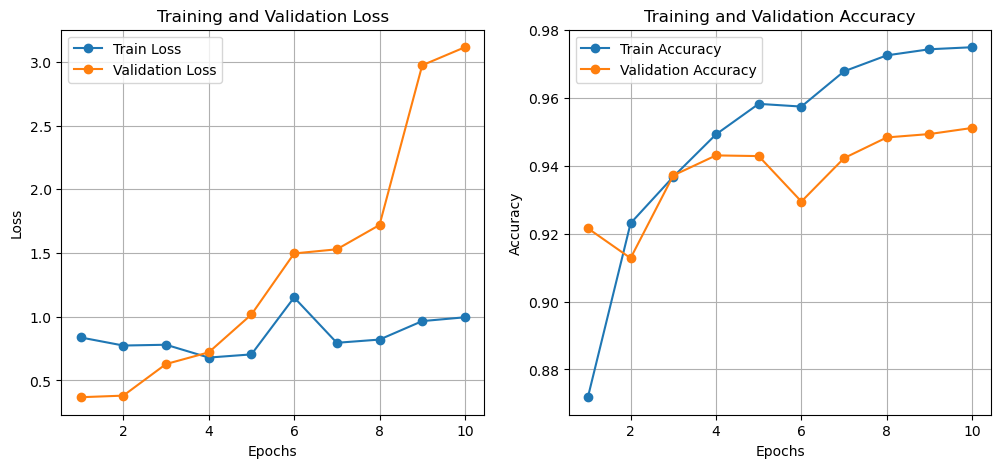

In [68]:
epochs = list(range(1, 11))
train_loss = [0.8373, 0.7737, 0.7799, 0.6792, 0.7042, 1.1512, 0.7952, 0.8205, 0.9655, 0.9956]
val_loss = [0.3679, 0.3804, 0.6284, 0.7202, 1.0175, 1.4966, 1.5293, 1.7200, 2.9742, 3.1159]
train_acc = [0.8718, 0.9231, 0.9368, 0.9493, 0.9583, 0.9575, 0.9679, 0.9726, 0.9744, 0.9750]
val_acc = [0.9216, 0.9128, 0.9372, 0.9431, 0.9429, 0.9295, 0.9423, 0.9484, 0.9494, 0.9512]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, train_loss, marker='o', linestyle='-', label='Train Loss')
ax[0].plot(epochs, val_loss, marker='o', linestyle='-', label='Validation Loss')
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
ax[1].plot(epochs, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid()

plt.show()

In [64]:
torch.save(vgg16.state_dict(), "vgg16_finetuned.pth")

vgg16.load_state_dict(torch.load("vgg16_finetuned.pth"))


C:\Users\elisa\AppData\Local\Temp\ipykernel_504\2957261070.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load("vgg16_finetuned.pth"))


<All keys matched successfully>

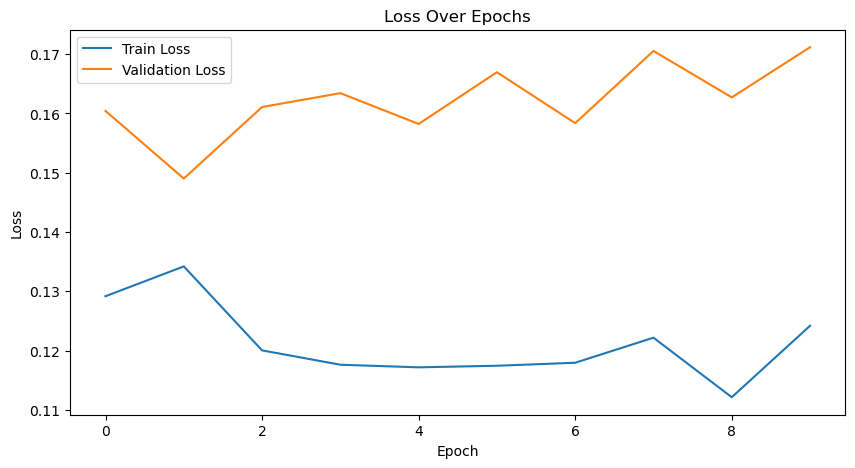

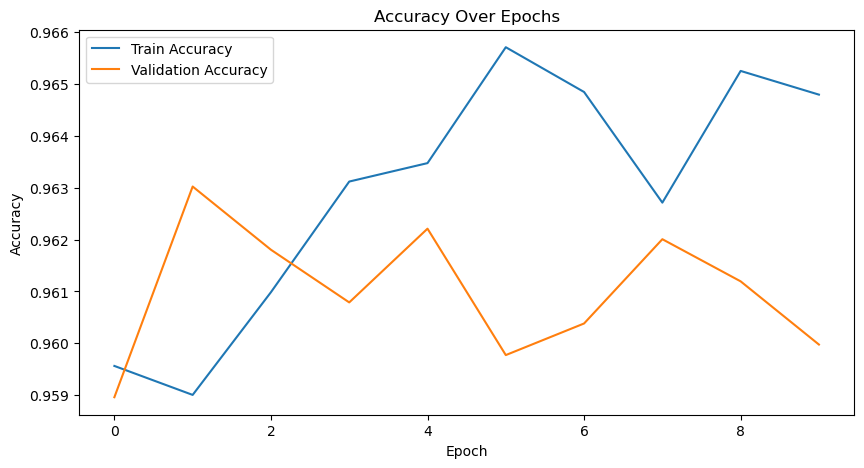

In [65]:
# Gráficos de perdas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()